In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from src.Transformer.DecoderOnly import SimplexDecoderOnlyTransformer
from src.Datasets.SyntheticDataset import SimplePeriodicDataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimplePeriodicDataset(len_timeseries=512, seq_len=48, shift=1)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# === Model ===
model = SimplexDecoderOnlyTransformer(
    d_in=dataset[0][0].shape[-1] + dataset[0][1].shape[-1],
    emb_size=64,
    num_layers=2,
    ffn_n_hidden=128
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Train Loop ===
train_losses, val_losses = [], []
for epoch in range(80):
    model.train()
    running_loss = 0
    for X, fX, _, y in train_loader:
        X, fX, y = X.to(device), fX.to(device), y.to(device)
        mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0).repeat(X.shape[0], 1, 1)

        optimizer.zero_grad()
        out = model(X, fX, mask=mask)
        loss = criterion(out[:, -1], y[:, -1])  # predict last step
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # === Validation ===
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for X, fX, _, y in val_loader:
            X, fX, y = X.to(device), fX.to(device), y.to(device)
            mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0).repeat(X.shape[0], 1, 1)
            out = model(X, fX, mask=mask)
            loss = criterion(out[:, -1], y[:, -1])
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

d:\Bestanden\Documenten\GitHub\attention_analysis\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Bestanden\Documenten\GitHub\attention_analysis\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Bestanden\Documenten\GitHub\attention_analysis\.venv\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29, 64])). This will likel

Epoch 01 | Train Loss: 5747.3944 | Val Loss: 5857.9831
Epoch 02 | Train Loss: 5585.2498 | Val Loss: 5568.7788
Epoch 03 | Train Loss: 5208.1708 | Val Loss: 4970.4152
Epoch 04 | Train Loss: 4394.4863 | Val Loss: 3965.4163
Epoch 05 | Train Loss: 3311.2048 | Val Loss: 2684.5020
Epoch 06 | Train Loss: 2143.8926 | Val Loss: 1531.6582
Epoch 07 | Train Loss: 1341.2729 | Val Loss: 919.7237
Epoch 08 | Train Loss: 1140.2428 | Val Loss: 794.6151
Epoch 09 | Train Loss: 1164.9187 | Val Loss: 808.6607
Epoch 10 | Train Loss: 1136.8811 | Val Loss: 810.9926
Epoch 11 | Train Loss: 1153.6565 | Val Loss: 797.4164
Epoch 12 | Train Loss: 1150.3356 | Val Loss: 768.2550
Epoch 13 | Train Loss: 1077.0260 | Val Loss: 703.5298
Epoch 14 | Train Loss: 1036.4527 | Val Loss: 644.8334
Epoch 15 | Train Loss: 1003.5061 | Val Loss: 595.7705
Epoch 16 | Train Loss: 1014.5050 | Val Loss: 577.4388
Epoch 17 | Train Loss: 992.3912 | Val Loss: 587.4941
Epoch 18 | Train Loss: 996.4895 | Val Loss: 576.4968
Epoch 19 | Train Loss: 9

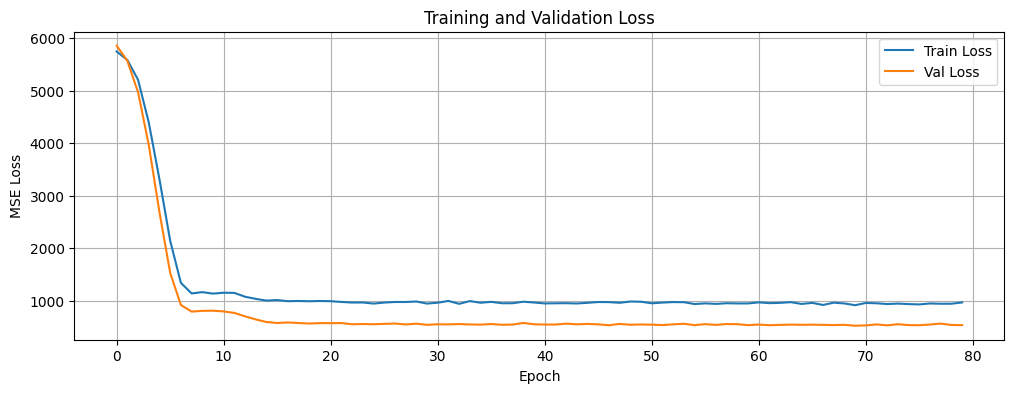

In [4]:
# === Plot Loss ===
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

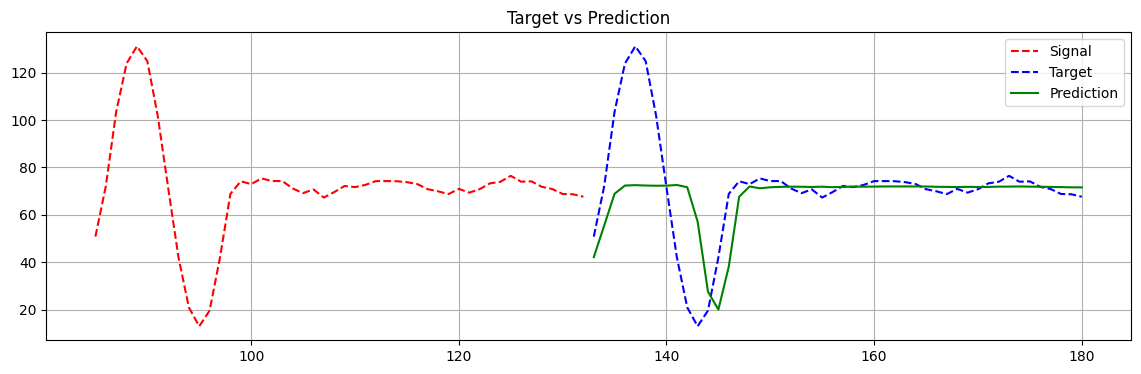

In [5]:
# === Visualize Prediction ===
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)
mask = torch.tril(torch.ones(X.shape[1], X.shape[1], device=device)).unsqueeze(0)

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(y)), y.cpu(), 'r--', label='Signal')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), y.cpu(), 'b--', label='Target')
plt.plot(range(start_idx + len(y), start_idx + 2 * len(y)), pred[-len(y):, 0], 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()

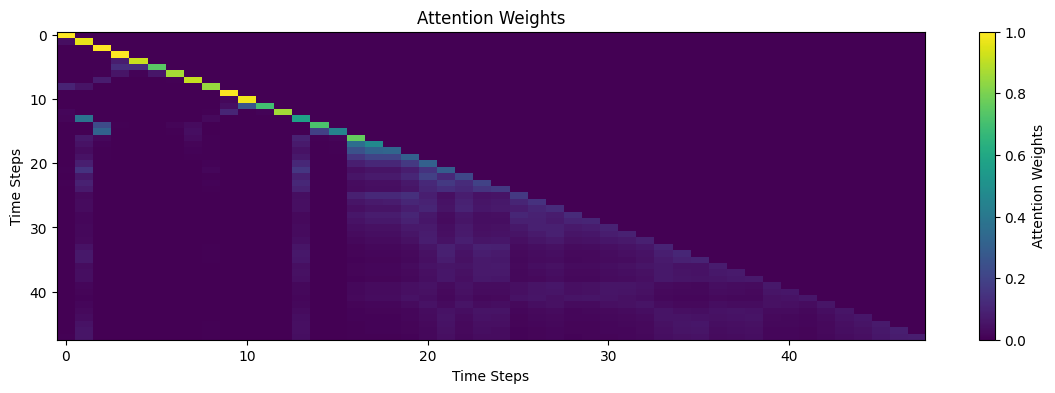

In [6]:
# visualize attention weights in a plot underneath the time series
plt.figure(figsize=(14, 4))
plt.imshow(model.transformer_blocks[0].attention.attention_weight.squeeze(0).cpu(), cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weights')
plt.title("Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
plt.show()


Text(0, 0.5, 'Time Steps')

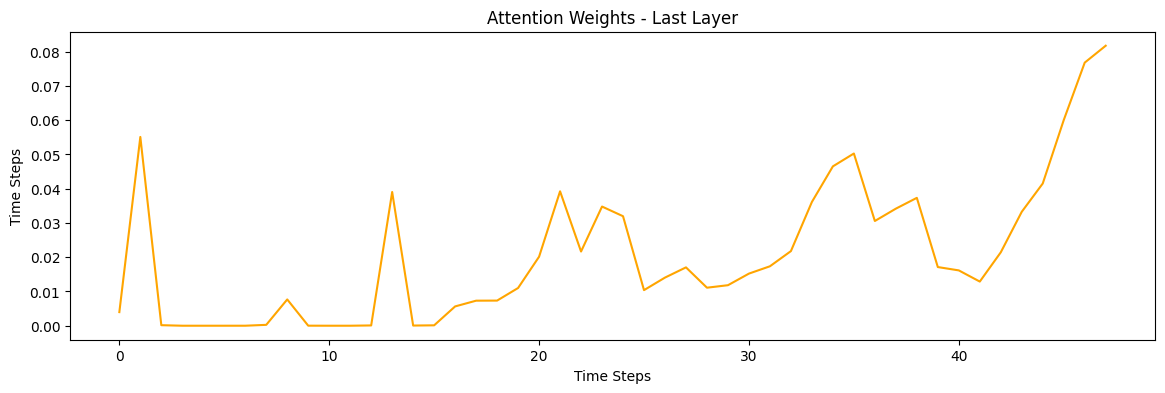

In [8]:
# Plot only last attention weights
plt.figure(figsize=(14, 4))
plt.plot(model.transformer_blocks[0].attention.attention_weight.squeeze(0).cpu()[-1, :], label='Attention Weights', color='orange')
plt.title("Attention Weights - Last Layer")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
